<h1> SA spending  </h1>

In [49]:
from __future__ import division
import psycopg2
import numpy as np
import json
import re
from ast import literal_eval
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns

from IPython.html.widgets import *
from nvd3 import pieChart
import nvd3
nvd3.ipynb.initialize_javascript(use_remote=True)

pd.set_option('display.max_rows', 6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<h1> Quick mapping from dates to quarters in the data </h1>

In [43]:
def quarter_map(year,month):
    val=0
    if ((year==2016) & (month>=4) & (month<=6)):
        val=1
    elif ((year==2016) & (month>=7) & (month<=9)):
        val=2
    elif ((year==2016) & (month>=10) & (month<=12)):
        val=3
    else:
        val=0
    return val

<h1> Load data </h1>

In [44]:
# read the entire file into a python array
with open('/Users/attiladobi/Downloads/za_integration.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF = pd.read_json(data_json_str)

#convert date:
DF['Date']=pd.to_datetime(DF['Real_Date'])
DF['day'] = pd.to_numeric(DF['Date'].dt.day)
DF['month'] = pd.to_numeric(DF['Date'].dt.month)
DF['year'] = pd.to_numeric(DF['Date'].dt.year)

#ADD Quarter mapping to the data
DF['Quarter']=[quarter_map(year,month) for year,month in DF[['year','month']].values]

<h1> View the data </h1>

In [47]:
DF.loc[(DF['field']=='spend') & (DF['year']<=2016)]

Real_Date beneficiary budget_line  \
2      2016-04-01         NaN         167   
5      2016-06-01         NaN         167   
...           ...         ...         ...   
66742  2016-08-01         NaN         319   
66745  2016-09-01         NaN         319   

                                        budget_line_full  \
2      167: child and youth care worker/chb carer and...   
5      167: child and youth care worker/chb carer and...   
...                                                  ...   
66742  319: laptop computer (inc software & installat...   
66745  319: laptop computer (inc software & installat...   

                        cost_category  \
2                     human resources   
5                     human resources   
...                               ...   
66742  9.0 non-health equipment (nhp)   
66745  9.0 non-health equipment (nhp)   

                                           description  field  \
2      child and youth care worker/chb carer and sweat  spend   
5      child and youth care worker/chb carer and sweat  spend   
...                                                ...    ...   
66742    laptop computer (inc software & installation)  spend   
66745    laptop computer (inc software & installation)  spend   

      invoice_receipt_number peer_motivator province   ...       subrecipient  \
2                        NaN            NaN      NaN   ...     munna ndi nnyi   
5                        NaN            NaN      NaN   ...     munna ndi nnyi   
...                      ...            ...      ...   ...                ...   
66742                    NaN            NaN      NaN   ...               wrhi   
66745                    NaN            NaN      NaN   ...               wrhi   

       suburb supplier_employee_name  transaction_reference       val  \
2         NaN                    NaN                    NaN      0.00   
5         NaN                    NaN                    NaN  25392.32   
...       ...                    ...                    ...       ...   
66742     NaN                    NaN                    NaN      0.00   
66745     NaN                    NaN                    NaN  32908.00   

            Date day month  year  Quarter  
2     2016-04-01   1     4  2016        1  
5     2016-06-01   1     6  2016        1  
...          ...  ..   ...   ...      ...  
66742 2016-08-01   1     8  2016        2  
66745 2016-09-01   1     9  2016        2  

[5738 rows x 25 columns]

<h1> plot monthly spending in each SR </h1>

In [50]:
#Sum over all budget_lines
#toplot=DF.loc[(DF['field']=='spend') & (DF['val']>0)].groupby(['subrecipient','Date','budget_line']).sum()['val']
plot_spend=DF.loc[(DF['field']=='spend') & (DF['year']<=2016) & (DF['Quarter']<=2)].groupby(['subrecipient','Date']).sum()['val']
plot_spend

subrecipient  Date      
cpc           2016-04-01    6.478360e+03
              2016-05-01    1.197560e+03
              2016-06-01    2.751854e+06
                                ...     
wrhi          2016-07-01    8.902305e+05
              2016-08-01    8.905172e+05
              2016-09-01    6.977455e+05
Name: val, dtype: float64

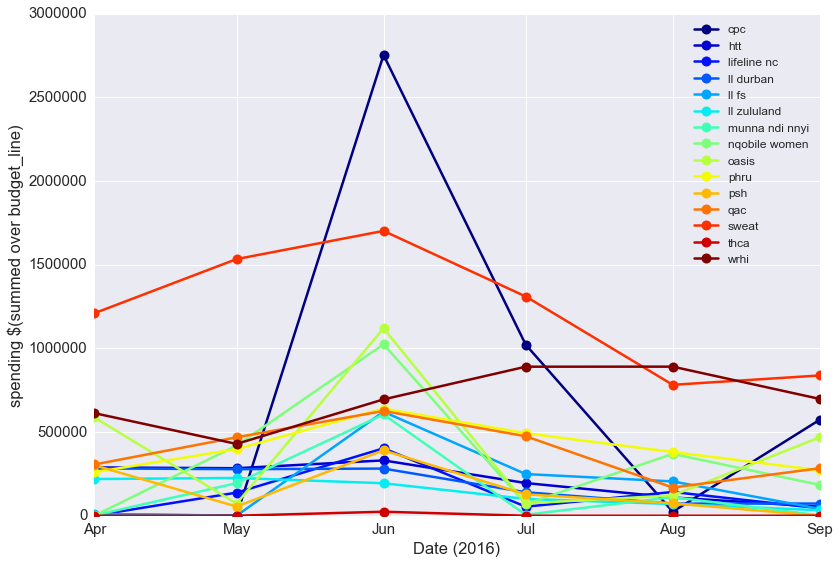

In [51]:
#plot spending per region

#setup colors
start,stop=0,1
number_of_colors= len(plot_spend.index.levels[0])
cm_subsection = linspace(start, stop, number_of_colors) 
colors = [ cm.jet(x) for x in cm_subsection ]

fig=figure()
fig.set_size_inches(13, 9)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for level,color in zip(plot_spend.index.levels[0],colors):
    plt.plot(plot_spend[level],'.-',color=color,markersize=20, label=level,)
ylabel('spending $(summed over budget_line)')
xlabel('Date (2016)')
legend(loc='upper right', numpoints=1,fontsize=12)
ax = gca()
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%Y'))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
#yscale('log')

<h1> Group by quarter </h1>

In [52]:
plot_spend=DF.loc[(DF['field']=='spend') & (DF['year']<=2016) & (DF['Quarter']<=2)].groupby(['subrecipient','Quarter']).sum()['val']
plot_spend

subrecipient  Quarter
cpc           1          2.759530e+06
              2          1.618566e+06
htt           1          9.026696e+05
                             ...     
thca          2          0.000000e+00
wrhi          1          1.736811e+06
              2          2.478493e+06
Name: val, dtype: float64

(0, 3)

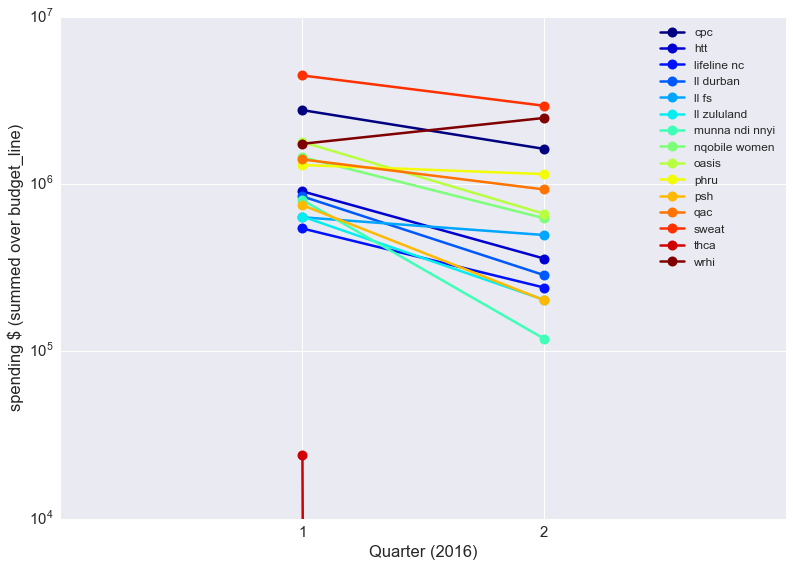

In [54]:
#plot spending per region

#setup colors
start,stop=0,1
number_of_colors= len(plot_spend.index.levels[0])
cm_subsection = linspace(start, stop, number_of_colors) 
colors = [ cm.jet(x) for x in cm_subsection ]

fig=figure()
fig.set_size_inches(13, 9)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for level,color in zip(plot_spend.index.levels[0],colors):
    plt.plot(plot_spend[level],'.-',color=color,markersize=20, label=level,)
ylabel('spending $ (summed over budget_line)')
xlabel('Quarter (2016)')
legend(loc='upper right', numpoints=1,fontsize=12)
ax = gca()
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%Y'))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
yscale('log')
xticks([1,2])
xlim(0,3)

<h1> Quarterly spending diplayed on pie chart for Q1 and Q2 </h1>

In [55]:
def pie_spend(q):
    
    quarter = q

    pie_plot=plot_spend[:,q] #get quartly breakdown
    
    #Make d3 graph
    
    # Open File to write the D3 Graph
    kwargs1 = {"fontSize": '100'}

    chart = pieChart(width=700, height=600, **kwargs1)
    xdata = pie_plot.index
    #xdata = ['one' , 'two', 'three', 'four']
    ydata1 = pie_plot.values
    extra_serie = {"tooltip": {"y_start": "", "y_end": " cal"}}

    chart.add_serie(title='Q1',name="Serie 1", y=ydata1, x=xdata, extra=extra_serie,**kwargs1)
    chart.buildhtml()

    print('Spending fraction \n Quarter: {:d}'.format(quarter))
    display(chart)

In [56]:
interact(pie_spend, q=(1,2,1) )

Spending fraction 
 Quarter: 1
